## 0. Install and Import Dependencies

In [41]:
#!pip install easyocr
#!pip install imutils

In [42]:
import cv2 
from matplotlib import pyplot as plt
import numpy as np
import imutils
import os
import pytesseract

## 1. Read in Image, Grayscale and Blur

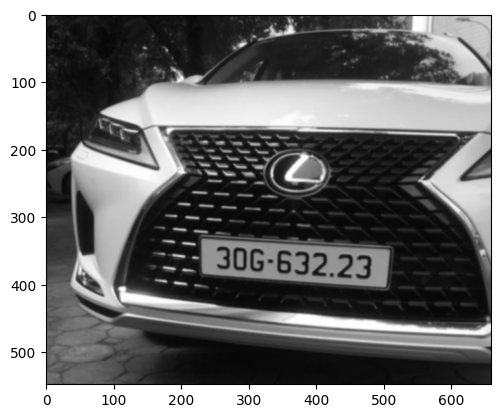

In [43]:
image = cv2.imread('image/image11.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))

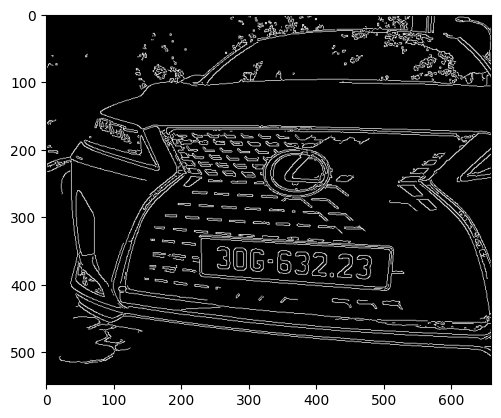

In [44]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

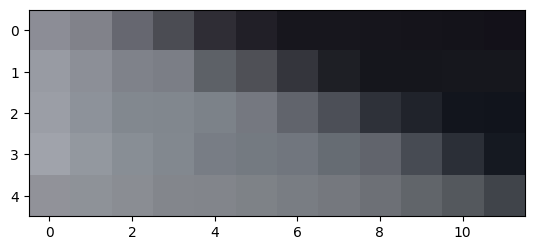

In [45]:
# Tìm các contour
contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
# Lọc các contour có thể là biển số xe
license_plate = None

for contour in contours:
    # Tìm hình chữ nhật xung quanh contour
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / float(h)
        
    # Kiểm tra tỷ lệ chiều dài, chiều cao phù hợp với biển số
    if 2 <= aspect_ratio <= 6:  # Giả định tỷ lệ của biển số
        license_plate = image[y:y + h, x:x + w]
        break

if license_plate is not None:
    license_plate_result = license_plate
else:
    license_plate_result = None

plt.imshow(cv2.cvtColor(license_plate, cv2.COLOR_BGR2RGB))


In [46]:
gray_plate = cv2.cvtColor(license_plate, cv2.COLOR_BGR2GRAY)

_, binary_plate = cv2.threshold(gray_plate, 128, 255, cv2.THRESH_BINARY_INV)

# Tìm các contour của các ký tự
contours, _ = cv2.findContours(binary_plate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

characters = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)

    # Cắt từng ký tự
    char_image = binary_plate[y:y + h, x:x + w]
    characters.append(char_image)

In [47]:
# Tạo thư mục nếu chưa tồn tại
output_folder = 'char_library'  # Replace with the actual path

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for idx, char_image in enumerate(characters):
    # Resize hình ảnh ký tự để OCR dễ nhận diện
    resized_char = cv2.resize(char_image, (50, 80))

    # Sử dụng Tesseract OCR để nhận diện ký tự
    recognized_char = pytesseract.image_to_string(resized_char, config='--psm 10').strip()

    # Kiểm tra ký tự có hợp lệ không (đảm bảo chỉ chứa ký tự hoặc số)
    if recognized_char.isalnum():
        char_path = f"{output_folder}/{recognized_char}.png"
    else:
        char_path = f"{output_folder}/unknown_{idx}.png"  # Nếu không nhận diện được thì lưu thành 'unknown'

    # Lưu ký tự thành file ảnh
    cv2.imwrite(char_path, char_image)